In [2]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,f_classif, chi2
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


# metrics evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# To standardise data
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

# For train/test split
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import VarianceThreshold as vt
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [3]:
#import CSVs, assign headers and remove quotations from column headers
white_wine = pd.read_csv(r'C:\Users\Killian\Projects\Wine analysis\Wine data\winequality-white.csv', sep=';',header=0, engine='python')

In [4]:
white_wine['label'] = white_wine['quality'].apply(lambda value: 'low'
if value <= 4 else 'medium-low'
if value == 5 else 'medium' if value == 6 else 'medium-high' if value == 7 else 'high')

In [5]:
wine = []
for column in white_wine.columns[0:-2]:
        wine.append([white_wine[column].astype(float).skew().round(2), white_wine[column].astype(float).kurt().round(2)])

wine_stats = pd.DataFrame(wine, index=[white_wine.columns[0:-2]], columns=['Skewness', 'Kurtosis'])
display(wine_stats)

,Skewness,Kurtosis
fixed acidity,0.65,2.17
volatile acidity,1.58,5.09
citric acid,1.28,6.17
residual sugar,1.08,3.47
chlorides,5.02,37.56
free sulfur dioxide,1.41,11.47
total sulfur dioxide,0.39,0.57
density,0.98,9.79
pH,0.46,0.53
sulphates,0.98,1.59


In [6]:

white_wine["label"].value_counts()

medium         2198
medium-low     1457
medium-high     880
low             183
high            180
Name: label, dtype: int64

In [7]:
white_wine['label'] = white_wine['quality'].apply(lambda value: 'low' if value <= 5 else 'medium' if value <=6 else 'high')
white_wine.head()
white_wine["label"].value_counts()

medium    2198
low       1640
high      1060
Name: label, dtype: int64

In [8]:
features=white_wine.columns
features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'label'],
      dtype='object')

In [9]:
white_wine['category'] = white_wine.label.map({"low" : "0", "medium" : "1", "high" : "2"}).astype('int')
white_wine= white_wine.drop(columns="quality")
print(white_wine.category.value_counts())
white_wine.category.dtypes


1    2198
0    1640
2    1060
Name: category, dtype: int64


dtype('int32')

In [10]:
white_wine.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label,category
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,medium,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,low,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,medium,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,high,2
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,medium,1


In [11]:
#Create target and features for algorithm
#Full feature list for ease of access while doing Backward Eliination and refining model: 'fixed acidity', 'volatile acidity', 'residual sugar', 'density', 'pH', 
# 'sulphates','citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol'
X = white_wine.copy()
y = X.category #target
X =white_wine.drop(columns=['category', 'label', 'citric acid', 'total sulfur dioxide', 'density', 'pH']) # features we want to test, except target and correlated values, i.e. Quality and Label. 
# Final list will include features removed due to results from Backward Elimination.
X_list = list(X.columns)
print(X.columns.tolist())
print(y)

['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'sulphates', 'alcohol']
0       1
1       1
2       1
3       1
4       1
       ..
4893    1
4894    0
4895    1
4896    2
4897    1
Name: category, Length: 4898, dtype: int32


In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #, stratify=y) # random state controls the shuffling applied before the split. 42 is a popular random seed.
#stratification ensures equitable split of low/medium/high quality across training and test data
print(Counter(y_train), Counter(y_test))
print('Features:', list(X))

Counter({1: 1530, 0: 1167, 2: 731}) Counter({1: 668, 0: 473, 2: 329})
Features: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'sulphates', 'alcohol']


In [13]:
# Because of the skewedness of the model, with many outliers, it does not seem appropriate to use either normalisation or
# standardisation. I will be applying a tree based algorithm which is insensitive to the scale of features as it splits
# nodes based on single features. 

#Below I am testing to make sure the shapes are as predicted (column numbers match)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (3428, 7)
Training Labels Shape: (3428,)
Testing Features Shape: (1470, 7)
Testing Labels Shape: (1470,)


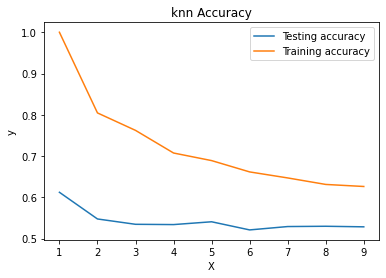

In [14]:
neighbors=np.arange(1,10)
train_accuracy=np.empty(len(neighbors))
test_accuracy=np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i]=knn.score(X_train, y_train)
    test_accuracy[i]=knn.score(X_test, y_test)

plt.title("knn Accuracy")
plt.plot(neighbors, test_accuracy, label="Testing accuracy")
plt.plot(neighbors, train_accuracy, label="Training accuracy")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [15]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
model.get_params() #See the parameters used 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [16]:
# make predictions for test data
#print(model.score(X_test, y_test))

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 54.08%


In [17]:
#Poor agreement = Less than 0.20 (including negative numbers)
#Fair agreement = 0.20 to 0.40
#Moderate agreement = 0.40 to 0.60
#Good agreement = 0.60 to 0.80
#Very good agreement = 0.80 to 1.00

# Cohen’s Kappa is a statistical measure that is used to measure the reliability of 
# two raters who are rating the same quantity and identifies how frequently the raters are in agreement. 


kappa = cohen_kappa_score(y_pred, y_test)
print("Cohen-Kappa score:", round(kappa, 2))

Cohen-Kappa score: 0.27


In [18]:
report = print(classification_report(y_test, y_pred, target_names=["low","medium", "high"]))

              precision    recall  f1-score   support

         low       0.52      0.58      0.55       473
      medium       0.54      0.58      0.56       668
        high       0.58      0.40      0.47       329

    accuracy                           0.54      1470
   macro avg       0.55      0.52      0.53      1470
weighted avg       0.54      0.54      0.54      1470



In [19]:
print("Confusion matrix:")
labels = np.unique(y_test)
a = confusion_matrix(y_test, y_pred, labels=labels)
a = pd.DataFrame(a, index=("low", "medium", "high"), columns=("low", "medium", "high"))
display(a)

Confusion matrix:


,low,medium,high
low,274,179,20
medium,205,390,73
high,51,147,131


In [20]:
#kfold = KFold(n_splits=10, random_state=7, shuffle=True)
print(cross_val_score(model, X, y, cv=3))

[0.45070423 0.4715248  0.45833333]


Best alpha using built-in LassoCV: 0.000467
Best score using built-in LassoCV: 0.284272
Lasso picked 6 variables and eliminated the other 1 variables


<AxesSubplot:>

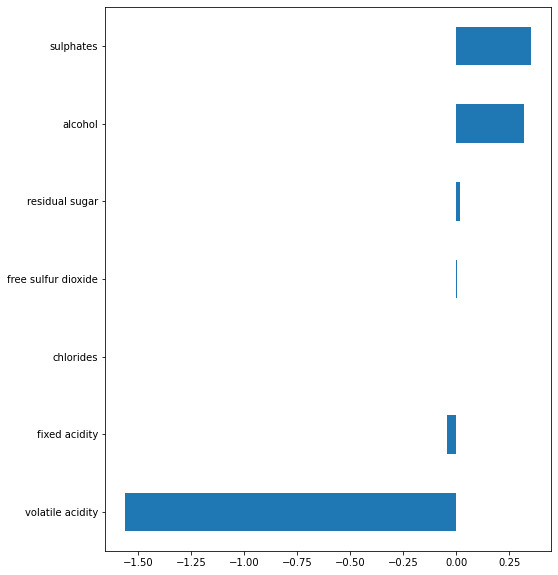

In [21]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")

In [22]:
#If you are set on using KNN though, then the best way to estimate feature importance is by 
# taking the sample to predict on, and computing its distance from each of its nearest neighbors 
# for each feature (call these neighb_dist). Then do the same computations for a few random points 
# (call these rand_dist) instead of the nearest neighbors. Then for each feature, you take the ratio 
# of neighb_dist / rand_dist, and the smaller the ratio, the more important that feature is.
